In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Usage
print("1. Loading data...")
sl_df = pd.read_csv(r"C:\Users\elangovan.paramasiva\Desktop\PROJECT\Code and Dataset\Dataset\slashdot_signed\Slashdot_Signed.txt", sep="\t")

print("Data loaded successfully.")
sl_df.head()


1. Loading data...
Data loaded successfully.


,FromNodeId,ToNodeId,Sign
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1


In [3]:
import pandas as pd


# Create a new DataFrame with the encoded SRC, TGT, and RES columns
encoded_df = sl_df[['FromNodeId', 'ToNodeId', 'Sign']]

# Print the resulting DataFrame
print("Encoded DataFrame:")
print(encoded_df.head())


Encoded DataFrame:
   FromNodeId  ToNodeId  Sign
0           0         1     1
1           0         2     1
2           0         3     1
3           0         4     1
4           0         5     1


In [4]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from collections import defaultdict
import networkx as nx

class FeatureBuilder:
    def __init__(self, edges_df):
        self.edges_df = edges_df
        self.pos_in_edges, self.pos_out_edges, self.neg_in_edges, self.neg_out_edges = self.initialize_edge_lists()
        self.G = self.create_graph()
        self.node_features = self.calculate_node_features()

    def initialize_edge_lists(self):
        pos_out = defaultdict(list)
        neg_out = defaultdict(list)
        pos_in = defaultdict(list)
        neg_in = defaultdict(list)
        
        for _, row in self.edges_df.iterrows():
            src, dst, sign = row['FromNodeId'], row['ToNodeId'], row['Sign']
            if sign == 1:
                pos_out[src].append(dst)
                pos_in[dst].append(src)
            else:
                neg_out[src].append(dst)
                neg_in[dst].append(src)
        
        return pos_in, pos_out, neg_in, neg_out

    def create_graph(self):
        G = nx.DiGraph()
        edges = list(zip(self.edges_df['FromNodeId'], self.edges_df['ToNodeId'], self.edges_df['Sign']))
        G.add_weighted_edges_from(edges)
        return G

    def calculate_node_features(self):
        degree = dict(self.G.degree())
        centrality = nx.degree_centrality(self.G)
        closeness_centrality = nx.closeness_centrality(self.G)
        katz_centrality = nx.katz_centrality(self.G, alpha=0.005)
        eigenvector_centrality = nx.eigenvector_centrality(self.G)
        clustering_coefficient = nx.clustering(self.G)
        
        def local_density(graph, node):
            neighbors = list(graph.neighbors(node))
            if len(neighbors) < 2:
                return 0
            subgraph = graph.subgraph(neighbors)
            return nx.density(subgraph)
        
        density = {node: local_density(self.G, node) for node in self.G.nodes()}
        
        node_features = {}
        for node in self.G.nodes():
            node_features[node] = (
                degree[node],
                centrality[node],
                closeness_centrality[node],
                density[node],
                katz_centrality[node],
                eigenvector_centrality[node],
                clustering_coefficient[node]
            )
        
        return node_features

    def calculate_degrees(self, node):
        return (len(self.pos_in_edges[node]), len(self.pos_out_edges[node]),
                len(self.neg_in_edges[node]), len(self.neg_out_edges[node]))

    def find_common_neighbors(self, node_a, node_b):
        a_neighbors = set(self.pos_in_edges[node_a] + self.neg_in_edges[node_a] +
                          self.pos_out_edges[node_a] + self.neg_out_edges[node_a])
        b_neighbors = set(self.pos_in_edges[node_b] + self.neg_in_edges[node_b] +
                          self.pos_out_edges[node_b] + self.neg_out_edges[node_b])
        return len(a_neighbors.intersection(b_neighbors))

    def compute_edge_features(self, node_a, node_b):
        pos_in_a, pos_out_a, neg_in_a, neg_out_a = self.calculate_degrees(node_a)
        pos_in_b, pos_out_b, neg_in_b, neg_out_b = self.calculate_degrees(node_b)
        common_neighbors = self.find_common_neighbors(node_a, node_b)
        total_out_a = pos_out_a + neg_out_a
        total_in_b = pos_in_b + neg_in_b
        
        part1 = (pos_in_a, neg_in_b, pos_out_a, neg_out_b, common_neighbors, total_out_a, total_in_b)

        I1 = len(set(self.pos_out_edges[node_a]).intersection(set(self.pos_in_edges[node_b])))
        I2 = len(set(self.pos_out_edges[node_a]).intersection(set(self.neg_in_edges[node_b])))
        I3 = len(set(self.neg_out_edges[node_a]).intersection(set(self.pos_in_edges[node_b])))
        I4 = len(set(self.neg_out_edges[node_a]).intersection(set(self.neg_in_edges[node_b])))

        I5 = len(set(self.pos_out_edges[node_a]).intersection(set(self.pos_out_edges[node_b])))
        I6 = len(set(self.pos_out_edges[node_a]).intersection(set(self.neg_out_edges[node_b])))
        I7 = len(set(self.neg_out_edges[node_a]).intersection(set(self.pos_out_edges[node_b])))
        I8 = len(set(self.neg_out_edges[node_a]).intersection(set(self.neg_out_edges[node_b])))

        I9 = len(set(self.pos_in_edges[node_a]).intersection(set(self.pos_out_edges[node_b])))
        I10 = len(set(self.pos_in_edges[node_a]).intersection(set(self.neg_out_edges[node_b])))
        I11 = len(set(self.neg_in_edges[node_a]).intersection(set(self.pos_out_edges[node_b])))
        I12 = len(set(self.neg_in_edges[node_a]).intersection(set(self.neg_out_edges[node_b])))

        I13 = len(set(self.pos_in_edges[node_a]).intersection(set(self.pos_in_edges[node_b])))
        I14 = len(set(self.pos_in_edges[node_a]).intersection(set(self.neg_in_edges[node_b])))
        I15 = len(set(self.neg_in_edges[node_a]).intersection(set(self.pos_in_edges[node_b])))
        I16 = len(set(self.neg_in_edges[node_a]).intersection(set(self.neg_in_edges[node_b])))

        part2 = (I1, I2, I3, I4, I5, I6, I7, I8, I9, I10, I11, I12, I13, I14, I15, I16)

        return part1 + part2

    def extract_features(self):
        features = []
        labels = []
        
        for _, row in self.edges_df.iterrows():
            u, v, label = row['FromNodeId'], row['ToNodeId'], row['Sign']
            edge_features = self.compute_edge_features(u, v)
            
            # Get pre-calculated node features
            from_node_features = self.node_features[u]
            to_node_features = self.node_features[v]
            
            # Concatenate the edge features and node features
            combined_features = edge_features + from_node_features + to_node_features
            
            features.append(combined_features)
            labels.append(int(label))  # Ensure label is an integer
        
        return np.array(features), np.array(labels)

In [5]:
# time taken 2 mins
print("\n2. Extracting features...")
feature_builder = FeatureBuilder(encoded_df)
features, labels = feature_builder.extract_features()
print(f"Features extracted. Shape: {features.shape}")


2. Extracting features...
Features extracted. Shape: (549202, 37)


In [6]:
encoded_df['Sign'] = pd.to_numeric(encoded_df['Sign'], errors='coerce')

In [7]:
from imblearn.over_sampling import SMOTE
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd


# Data Preprocessing and Splitting
print("\n3. Preprocessing and splitting data...")
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)


# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Check the distribution after resampling
y_train_series = pd.Series(y_train)
print(y_train_series.value_counts())

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Create edge_index for the entire graph
edge_index = torch.tensor(encoded_df[['FromNodeId', 'ToNodeId']].values.T, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create Data objects for train and test sets
train_data_gcn = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor)
test_data_gcn = Data(x=X_test_tensor, edge_index=edge_index, y=y_test_tensor)


print("Data preprocessing and splitting completed.")



3. Preprocessing and splitting data...
 1    297446
-1    297446
Name: count, dtype: int64
Data preprocessing and splitting completed.


In [12]:
from torch_geometric.nn import GCNConv
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)
        return x

# Define the SignedGCN model
class SignedGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SignedGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x

# Define the PINN model
class PINN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.tanh(self.bn1(self.fc1(x)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = torch.tanh(self.bn2(self.fc2(x)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)
        return x.squeeze()
   
def physics_loss(pred, density, average_clustering):
    # Assuming pred is a 1D tensor of shape (batch_size,)
    predicted_density = torch.mean(torch.sigmoid(pred))  # Use sigmoid instead of exp for numerical stability
    predicted_clustering = torch.mean(torch.sigmoid(pred))  # You might want to differentiate this from density

    density_loss = (predicted_density - density) ** 2
    clustering_loss = (predicted_clustering - average_clustering) ** 2

    return density_loss + clustering_loss

In [13]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, model_name, density=None, average_clustering=None):
    epoch_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        if model_name == 'SignedGCN':
            optimizer.zero_grad()
            out = model(train_loader.x, train_loader.edge_index)
            loss = criterion(out.squeeze(), (train_loader.y + 1) / 2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        else:
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                output = model(batch_x)
                data_loss = criterion(output.squeeze(), (batch_y + 1) / 2)
                if model_name == 'PINN':
                    phys_loss = physics_loss(output.squeeze(), density, average_clustering)
                    loss = data_loss + 0.1 * phys_loss  # Adjust the weight of physics loss
                else:
                    loss = data_loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        
        epoch_losses.append(total_loss)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1:03d}, Loss: {total_loss:.4f}')
    return epoch_losses

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve as pr_curve


def evaluate_model(model, test_loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        if model_name == 'SignedGCN':
            output = model(test_loader.x, test_loader.edge_index)
            probs = torch.sigmoid(output.squeeze())
            preds = (probs > 0.5).float() * 2 - 1  # Convert to [-1, 1]
            all_preds = preds.cpu().numpy()
            all_labels = test_loader.y.cpu().numpy()
            all_probs = probs.cpu().numpy()
        else:
            for batch_x, batch_y in test_loader:
                output = model(batch_x)
                probs = torch.sigmoid(output.squeeze())
                preds = (probs > 0.5).float() * 2 - 1
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, pos_label=1)
    recall = recall_score(all_labels, all_preds, pos_label=1)
    f1 = f1_score(all_labels, all_preds, pos_label=1)
    cm = confusion_matrix(all_labels, all_preds)

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    precision_vals, recall_vals, _ = pr_curve(all_labels, all_probs)
    pr_auc = auc(recall_vals, precision_vals)

    negative_accuracy = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    print(f'Negative Prediction Accuracy: {negative_accuracy:.4f}')
    print("\nConfusion Matrix:")
    print(cm)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'pr_curve': (precision_vals, recall_vals),
        'pr_auc': pr_auc,
        'predictions': all_preds,
        'probabilities': all_probs,
        'negative_accuracy': negative_accuracy
    }

In [15]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Model parameters
input_dim = features.shape[1]
hidden_dim = 64
output_dim = 1  # Binary classification for MLP and SignedGCN, 2 for PINN

# Initialize models
mlp_model = MLP(input_dim, hidden_dim, output_dim)
gcn_model = SignedGCN(input_dim, hidden_dim, output_dim)
pinn_model = PINN(input_dim, hidden_dim, output_dim)

# Training and evaluation for MLP
print("\nTraining MLP model...")
mlp_criterion = torch.nn.BCEWithLogitsLoss()
mlp_optimizer = Adam(mlp_model.parameters(), lr=0.001)
mlp_epoch_losses = train_model(mlp_model, train_loader, mlp_criterion, mlp_optimizer, num_epochs=50, model_name='MLP')




Training MLP model...
Epoch: 010, Loss: 3259.1499
Epoch: 020, Loss: 3184.2103
Epoch: 030, Loss: 3147.7484
Epoch: 040, Loss: 3127.3164
Epoch: 050, Loss: 3098.0893


In [16]:
print("\nEvaluating MLP model...")
mlp_metrics = evaluate_model(mlp_model, test_loader, 'MLP')


Evaluating MLP model...
Test Accuracy: 0.7632
Test Precision: 0.9767
Test Recall: 0.7112
Test F1 Score: 0.8231
Negative Prediction Accuracy: 0.9418

Confusion Matrix:
[[34974  2161]
 [36861 90765]]


In [20]:
# Training and evaluation for SignedGCN
print("\nTraining SignedGCN model...")
gcn_criterion = torch.nn.BCEWithLogitsLoss()
gcn_optimizer = Adam(gcn_model.parameters(), lr=0.001)
gcn_epoch_losses = train_model(gcn_model, train_data_gcn, gcn_criterion, gcn_optimizer, num_epochs=50, model_name='SignedGCN')



Training SignedGCN model...
Epoch: 010, Loss: 0.6744
Epoch: 020, Loss: 0.6443
Epoch: 030, Loss: 0.6135
Epoch: 040, Loss: 0.5811
Epoch: 050, Loss: 0.5510


In [21]:
print("\nEvaluating SignedGCN model...")
gcn_metrics = evaluate_model(gcn_model, test_data_gcn, 'SignedGCN')


Evaluating SignedGCN model...
Test Accuracy: 0.7628
Test Precision: 0.8700
Test Recall: 0.8157
Test F1 Score: 0.8419
Negative Prediction Accuracy: 0.5810

Confusion Matrix:
[[ 21576  15559]
 [ 23525 104101]]


In [17]:
# Create graph
G = nx.from_pandas_edgelist(encoded_df, 'FromNodeId', 'ToNodeId', edge_attr=True, create_using=nx.DiGraph())

# Calculate graph-level attributes
density = nx.density(G)
average_clustering = nx.average_clustering(G)
# diameter shows error bcoz network was not strongly connected but if run takes 730+mins
#diameter = nx.diameter(G) 
assortativity = nx.degree_assortativity_coefficient(G)
transitivity = nx.transitivity(G)


print("\nTraining PINN model...")
# For all models, including PINN
pinn_criterion = torch.nn.BCEWithLogitsLoss()
pinn_optimizer = Adam(pinn_model.parameters(), lr=0.001)
pinn_epoch_losses = train_model(pinn_model, train_loader, pinn_criterion, pinn_optimizer, num_epochs=50, model_name='PINN', density=density, average_clustering=average_clustering)



Training PINN model...
Epoch: 010, Loss: 3572.4402
Epoch: 020, Loss: 3525.9823
Epoch: 030, Loss: 3500.6656
Epoch: 040, Loss: 3489.2929
Epoch: 050, Loss: 3474.8731


In [18]:
print("\nEvaluating PINN model...")
pinn_metrics = evaluate_model(pinn_model, test_loader, 'PINN')


Evaluating PINN model...
Test Accuracy: 0.8425
Test Precision: 0.9710
Test Recall: 0.8212
Test F1 Score: 0.8899
Negative Prediction Accuracy: 0.9158

Confusion Matrix:
[[ 34009   3126]
 [ 22820 104806]]


c:\Users\elangovan.paramasiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\elangovan.paramasiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\elangovan.paramasiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence

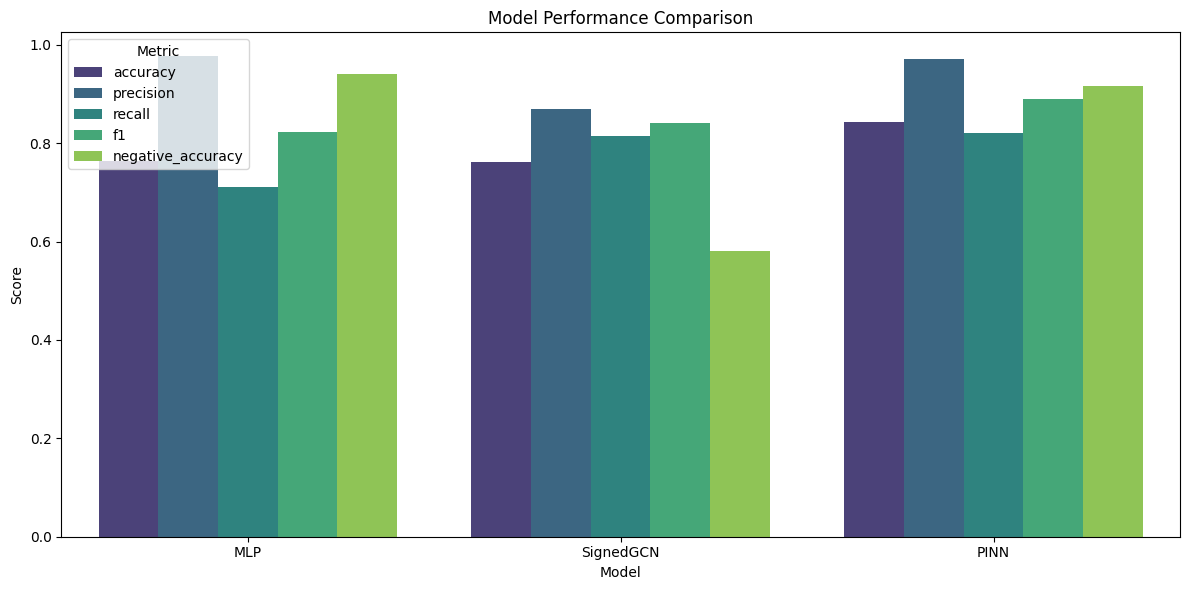

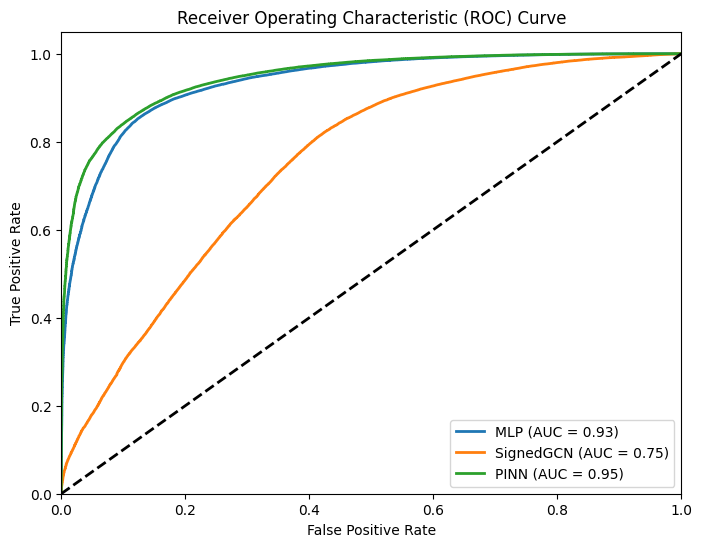

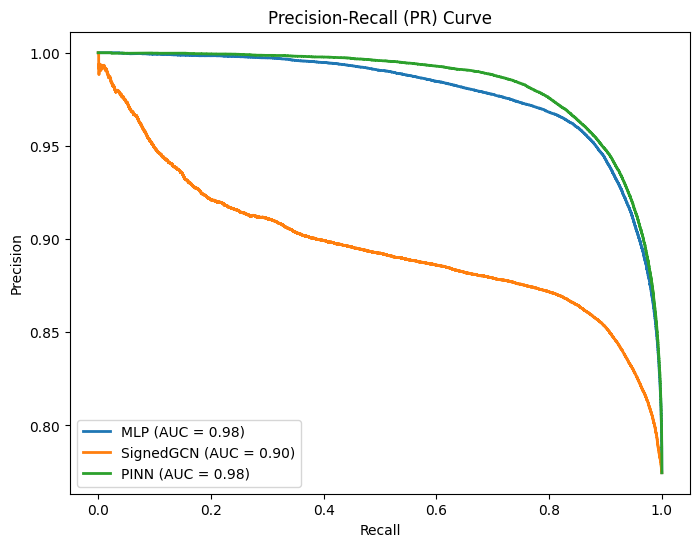

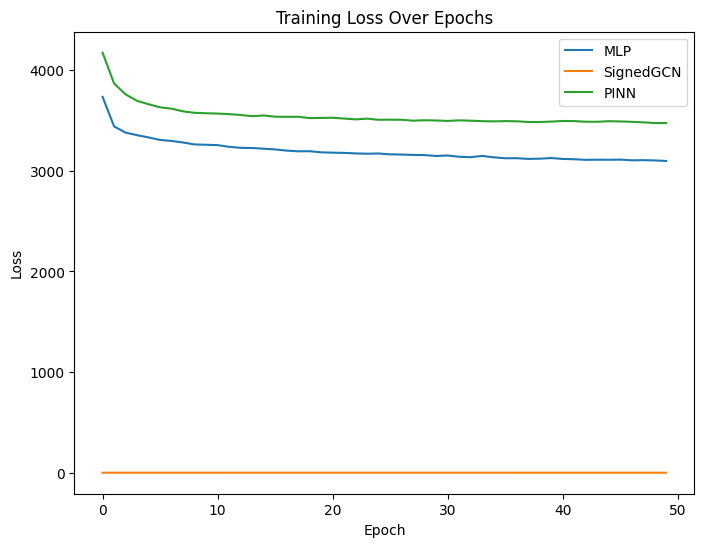

In [22]:
# Prepare data for plotting
metrics_df = pd.DataFrame([mlp_metrics, gcn_metrics, pinn_metrics], index=['MLP', 'SignedGCN', 'PINN'])
metrics_df = metrics_df[['accuracy', 'precision', 'recall', 'f1', 'negative_accuracy']].reset_index().melt(id_vars='index', var_name='metric', value_name='value')

# Plot accuracy, precision, recall, F1 score, and negative prediction accuracy
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x='index', y='value', hue='metric', palette='viridis')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(mlp_metrics['fpr'], mlp_metrics['tpr'], lw=2, label=f'MLP (AUC = {mlp_metrics["roc_auc"]:.2f})')
plt.plot(gcn_metrics['fpr'], gcn_metrics['tpr'], lw=2, label=f'SignedGCN (AUC = {gcn_metrics["roc_auc"]:.2f})')
plt.plot(pinn_metrics['fpr'], pinn_metrics['tpr'], lw=2, label=f'PINN (AUC = {pinn_metrics["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall (PR) curves
plt.figure(figsize=(8, 6))
plt.plot(mlp_metrics['pr_curve'][1], mlp_metrics['pr_curve'][0], lw=2, label=f'MLP (AUC = {mlp_metrics["pr_auc"]:.2f})')
plt.plot(gcn_metrics['pr_curve'][1], gcn_metrics['pr_curve'][0], lw=2, label=f'SignedGCN (AUC = {gcn_metrics["pr_auc"]:.2f})')
plt.plot(pinn_metrics['pr_curve'][1], pinn_metrics['pr_curve'][0], lw=2, label=f'PINN (AUC = {pinn_metrics["pr_auc"]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower left')
plt.show()

# Plot epoch loss graph
plt.figure(figsize=(8, 6))
plt.plot(mlp_epoch_losses, label='MLP')
plt.plot(gcn_epoch_losses, label='SignedGCN')
plt.plot(pinn_epoch_losses, label='PINN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve as pr_curve

def evaluate_model(model, test_loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        if model_name == 'SignedGCN':
            output = model(test_loader.x, test_loader.edge_index)
            probs = torch.sigmoid(output.squeeze())
            preds = (probs > 0.5).float() * 2 - 1  # Convert to [-1, 1]
            all_preds = preds.cpu().numpy()
            all_labels = test_loader.y.cpu().numpy()
            all_probs = probs.cpu().numpy()
        else:
            for batch_x, batch_y in test_loader:
                output = model(batch_x)
                probs = torch.sigmoid(output.squeeze())
                preds = (probs > 0.5).float() * 2 - 1
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())


    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Overall metrics
    overall_accuracy = accuracy_score(all_labels, all_preds)
    overall_precision = precision_score(all_labels, all_preds, average='binary', pos_label=1)
    overall_recall = recall_score(all_labels, all_preds, average='binary', pos_label=1)
    overall_f1 = f1_score(all_labels, all_preds, average='binary', pos_label=1)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Positive class metrics
    positive_accuracy = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if cm[1, 0] + cm[1, 1] > 0 else 0
    positive_precision = precision_score(all_labels, all_preds, pos_label=1)
    positive_recall = recall_score(all_labels, all_preds, pos_label=1)
    positive_f1 = f1_score(all_labels, all_preds, pos_label=1)

    # Negative class metrics
    negative_accuracy = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if cm[0, 0] + cm[0, 1] > 0 else 0
    negative_precision = precision_score(all_labels, all_preds, pos_label=-1)
    negative_recall = recall_score(all_labels, all_preds, pos_label=-1)
    negative_f1 = f1_score(all_labels, all_preds, pos_label=-1)

    # ROC and PR curves
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    precision_vals, recall_vals, _ = pr_curve(all_labels, all_probs)
    pr_auc = auc(recall_vals, precision_vals)

    # Store metrics in a dictionary
    metrics = {
        'overall': {
            'accuracy': overall_accuracy,
            'precision': overall_precision,
            'recall': overall_recall,
            'f1': overall_f1
        },
        'positive': {
            'accuracy': positive_accuracy,
            'precision': positive_precision,
            'recall': positive_recall,
            'f1': positive_f1
        },
        'negative': {
            'accuracy': negative_accuracy,
            'precision': negative_precision,
            'recall': negative_recall,
            'f1': negative_f1
        },
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'fpr': fpr,
        'tpr': tpr,
        'pr_curve': (precision_vals, recall_vals)
    }

    print('Overall Metrics:')
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Precision: {overall_precision:.4f}")
    print(f"Recall: {overall_recall:.4f}")
    print(f"F1 Score: {overall_f1:.4f}")

    print('\nPositive Class Metrics:')
    print(f"Accuracy: {positive_accuracy:.4f}")
    print(f"Precision: {positive_precision:.4f}")
    print(f"Recall: {positive_recall:.4f}")
    print(f"F1 Score: {positive_f1:.4f}")

    print('\nNegative Class Metrics:')
    print(f"Accuracy: {negative_accuracy:.4f}")
    print(f"Precision: {negative_precision:.4f}")
    print(f"Recall: {negative_recall:.4f}")
    print(f"F1 Score: {negative_f1:.4f}")

    print("\nConfusion Matrix:")
    print(cm)

    return metrics

In [25]:
print("\nEvaluating MLP model...")
mlp_metrics = evaluate_model(mlp_model, test_loader, 'MLP')


Evaluating MLP model...
Overall Metrics:
Accuracy: 0.7632
Precision: 0.9767
Recall: 0.7112
F1 Score: 0.8231

Positive Class Metrics:
Accuracy: 0.7112
Precision: 0.9767
Recall: 0.7112
F1 Score: 0.8231

Negative Class Metrics:
Accuracy: 0.9418
Precision: 0.4869
Recall: 0.9418
F1 Score: 0.6419

Confusion Matrix:
[[34974  2161]
 [36861 90765]]


In [26]:
print("\nEvaluating SignedGCN model...")
gcn_metrics = evaluate_model(gcn_model, test_data_gcn, 'SignedGCN')


Evaluating SignedGCN model...
Overall Metrics:
Accuracy: 0.7628
Precision: 0.8700
Recall: 0.8157
F1 Score: 0.8419

Positive Class Metrics:
Accuracy: 0.8157
Precision: 0.8700
Recall: 0.8157
F1 Score: 0.8419

Negative Class Metrics:
Accuracy: 0.5810
Precision: 0.4784
Recall: 0.5810
F1 Score: 0.5247

Confusion Matrix:
[[ 21576  15559]
 [ 23525 104101]]


In [27]:
print("\nEvaluating PINN model...")
pinn_metrics = evaluate_model(pinn_model, test_loader, 'PINN')


Evaluating PINN model...
Overall Metrics:
Accuracy: 0.8425
Precision: 0.9710
Recall: 0.8212
F1 Score: 0.8899

Positive Class Metrics:
Accuracy: 0.8212
Precision: 0.9710
Recall: 0.8212
F1 Score: 0.8899

Negative Class Metrics:
Accuracy: 0.9158
Precision: 0.5984
Recall: 0.9158
F1 Score: 0.7239

Confusion Matrix:
[[ 34009   3126]
 [ 22820 104806]]


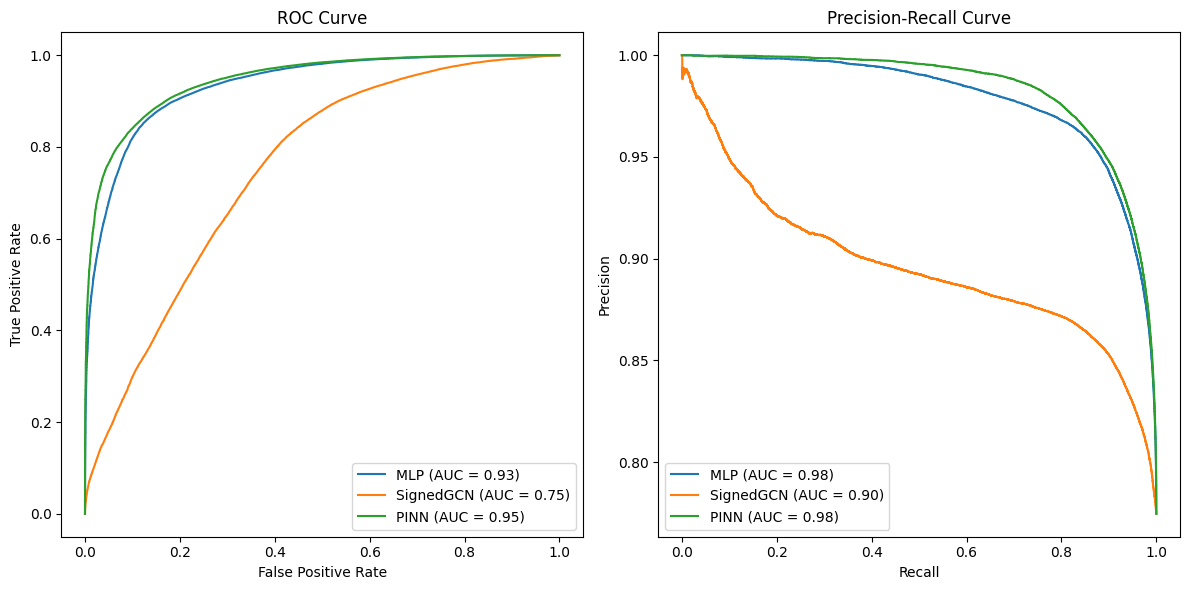

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_roc_pr_curves(metrics_dict):
    """Plot ROC and PR curves for different models."""
    plt.figure(figsize=(12, 6))
    
    # Plot ROC curves
    plt.subplot(1, 2, 1)
    for model_name, metrics in metrics_dict.items():
        plt.plot(metrics['fpr'], metrics['tpr'], label=f'{model_name} (AUC = {metrics["roc_auc"]:.2f})')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    
    # Plot PR curves
    plt.subplot(1, 2, 2)
    for model_name, metrics in metrics_dict.items():
        precision_vals, recall_vals = metrics['pr_curve']
        plt.plot(recall_vals, precision_vals, label=f'{model_name} (AUC = {metrics["pr_auc"]:.2f})')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()


# Assuming mlp_metrics, gcn_metrics, pinn_metrics are dictionaries containing the metrics for each model
metrics_dict = {
    'MLP': mlp_metrics,
    'SignedGCN': gcn_metrics,
    'PINN': pinn_metrics
}

# Plot ROC and PR curves
plot_roc_pr_curves(metrics_dict)


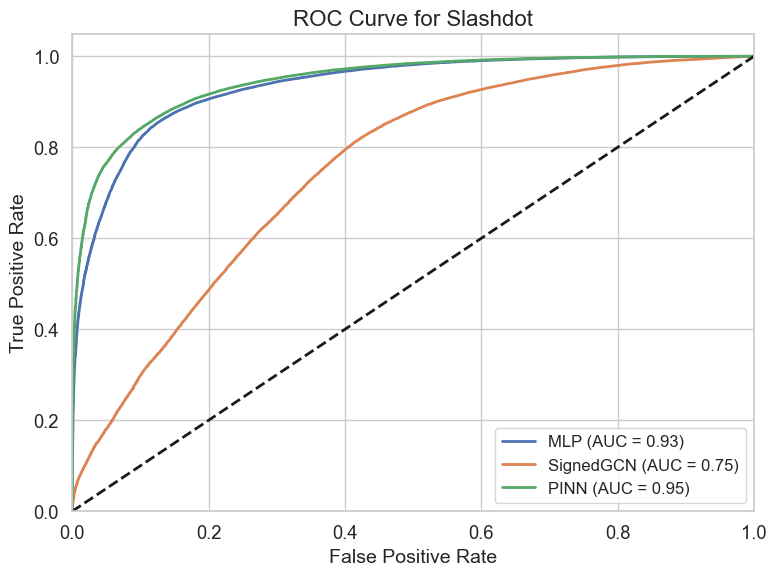

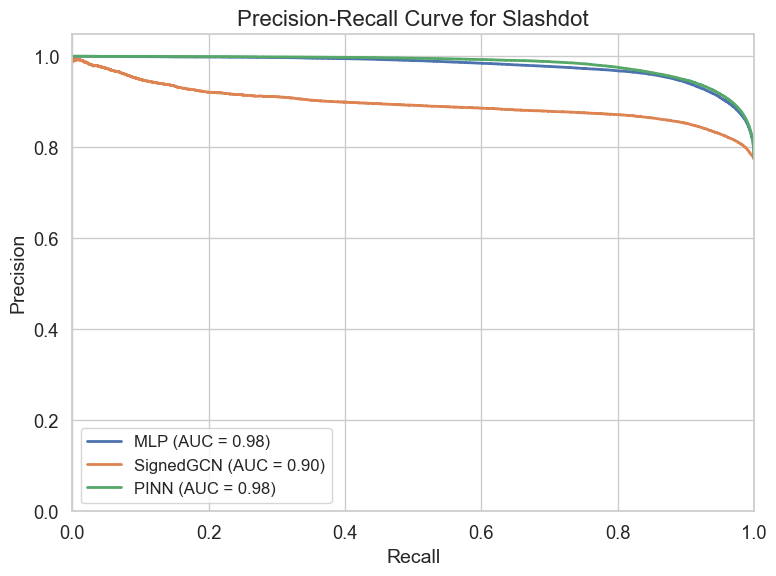

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for a professional look
sns.set(style="whitegrid", font_scale=1.2)

def plot_roc_curve(metrics_dict):
    """Plot ROC curves for different models."""
    plt.figure(figsize=(8, 6))
    
    for model_name, metrics in metrics_dict.items():
        plt.plot(metrics['fpr'], metrics['tpr'], label=f'{model_name} (AUC = {metrics["roc_auc"]:.2f})', lw=2)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.title('ROC Curve for Slashdot', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_pr_curve(metrics_dict):
    """Plot PR curves for different models."""
    plt.figure(figsize=(8, 6))
    
    for model_name, metrics in metrics_dict.items():
        precision_vals, recall_vals = metrics['pr_curve']
        plt.plot(recall_vals, precision_vals, label=f'{model_name} (AUC = {metrics["pr_auc"]:.2f})', lw=2)
    
    plt.title('Precision-Recall Curve for Slashdot', fontsize=16)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.legend(loc='lower left', fontsize=12)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Assuming mlp_metrics, gcn_metrics, pinn_metrics, gat_metrics are dictionaries containing the metrics for each model
metrics_dict = {
    'MLP': mlp_metrics,
    'SignedGCN': gcn_metrics,
    'PINN': pinn_metrics,
}

# Plot ROC and PR curves separately
plot_roc_curve(metrics_dict)
plot_pr_curve(metrics_dict)


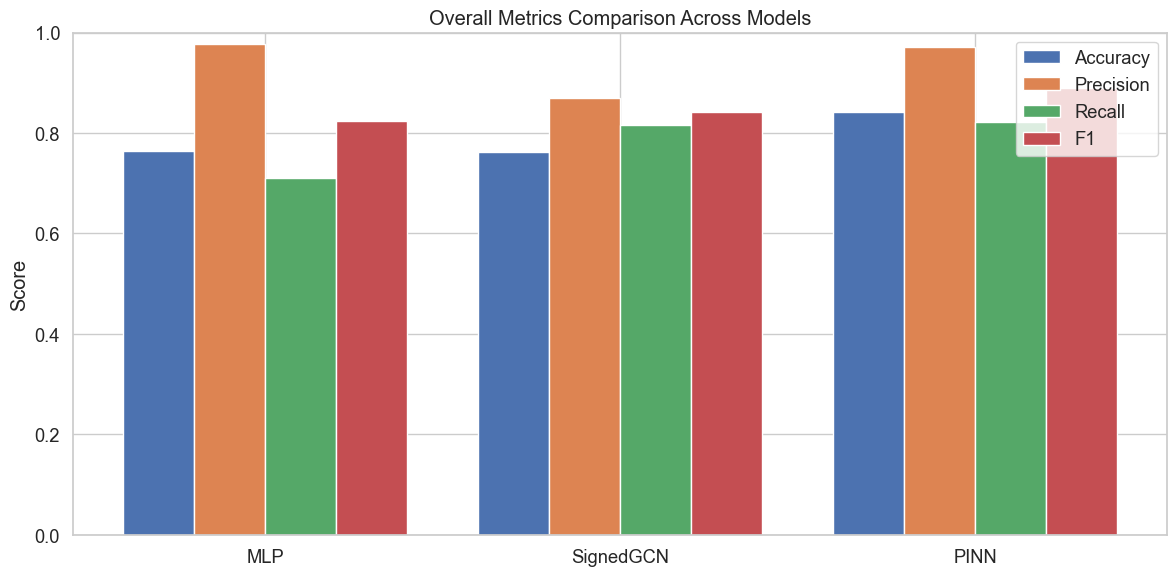

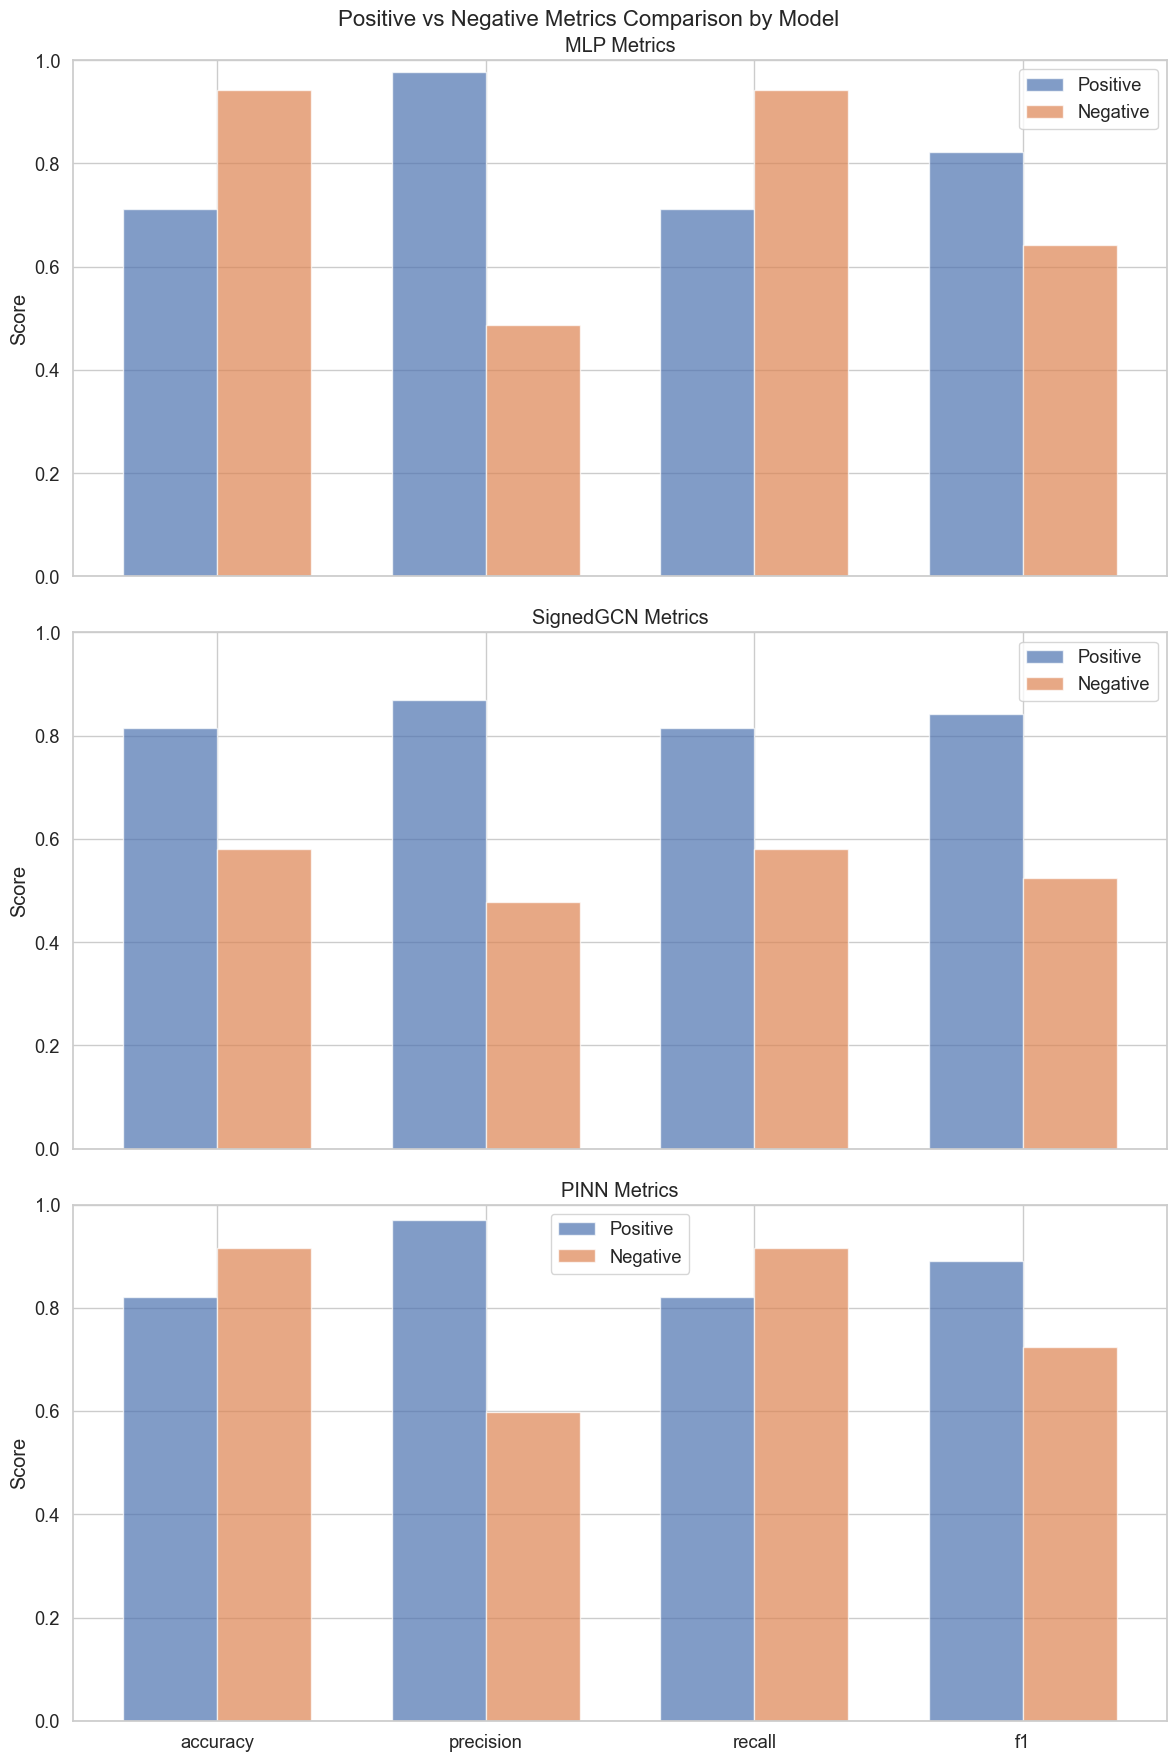

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_overall_metrics(metrics_dict):
    """Plot overall metrics for all models in a single bar chart."""
    models = list(metrics_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    x = np.arange(len(models))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, metric in enumerate(metrics):
        values = [metrics_dict[model]['overall'][metric] for model in models]
        ax.bar(x + i*width, values, width, label=metric.capitalize())
    
    ax.set_ylabel('Score')
    ax.set_title('Overall Metrics Comparison Across Models')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(models)
    ax.legend(loc='best')
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def plot_positive_negative_comparison(metrics_dict):
    """Plot positive and negative metrics comparison for each model in a bar chart."""
    models = list(metrics_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, axs = plt.subplots(len(models), 1, figsize=(12, 6*len(models)), sharex=True)
    fig.suptitle('Positive vs Negative Metrics Comparison by Model', fontsize=16)
    
    for i, (model, ax) in enumerate(zip(models, axs)):
        positive_values = [metrics_dict[model]['positive'][metric] for metric in metrics]
        negative_values = [metrics_dict[model]['negative'][metric] for metric in metrics]
        
        ax.bar(x - width/2, positive_values, width, label='Positive',  alpha=0.7)
        ax.bar(x + width/2, negative_values, width, label='Negative', alpha=0.7)
        
        ax.set_ylabel('Score')
        ax.set_title(f'{model} Metrics')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend(loc='best')
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Assuming metrics_dict is your dictionary containing metrics for all models
metrics_dict = {
    'MLP': mlp_metrics,
    'SignedGCN': gcn_metrics,
    'PINN': pinn_metrics
}

# Plot overall metrics comparison
plot_overall_metrics(metrics_dict)

# Plot positive vs negative metrics comparison
plot_positive_negative_comparison(metrics_dict)

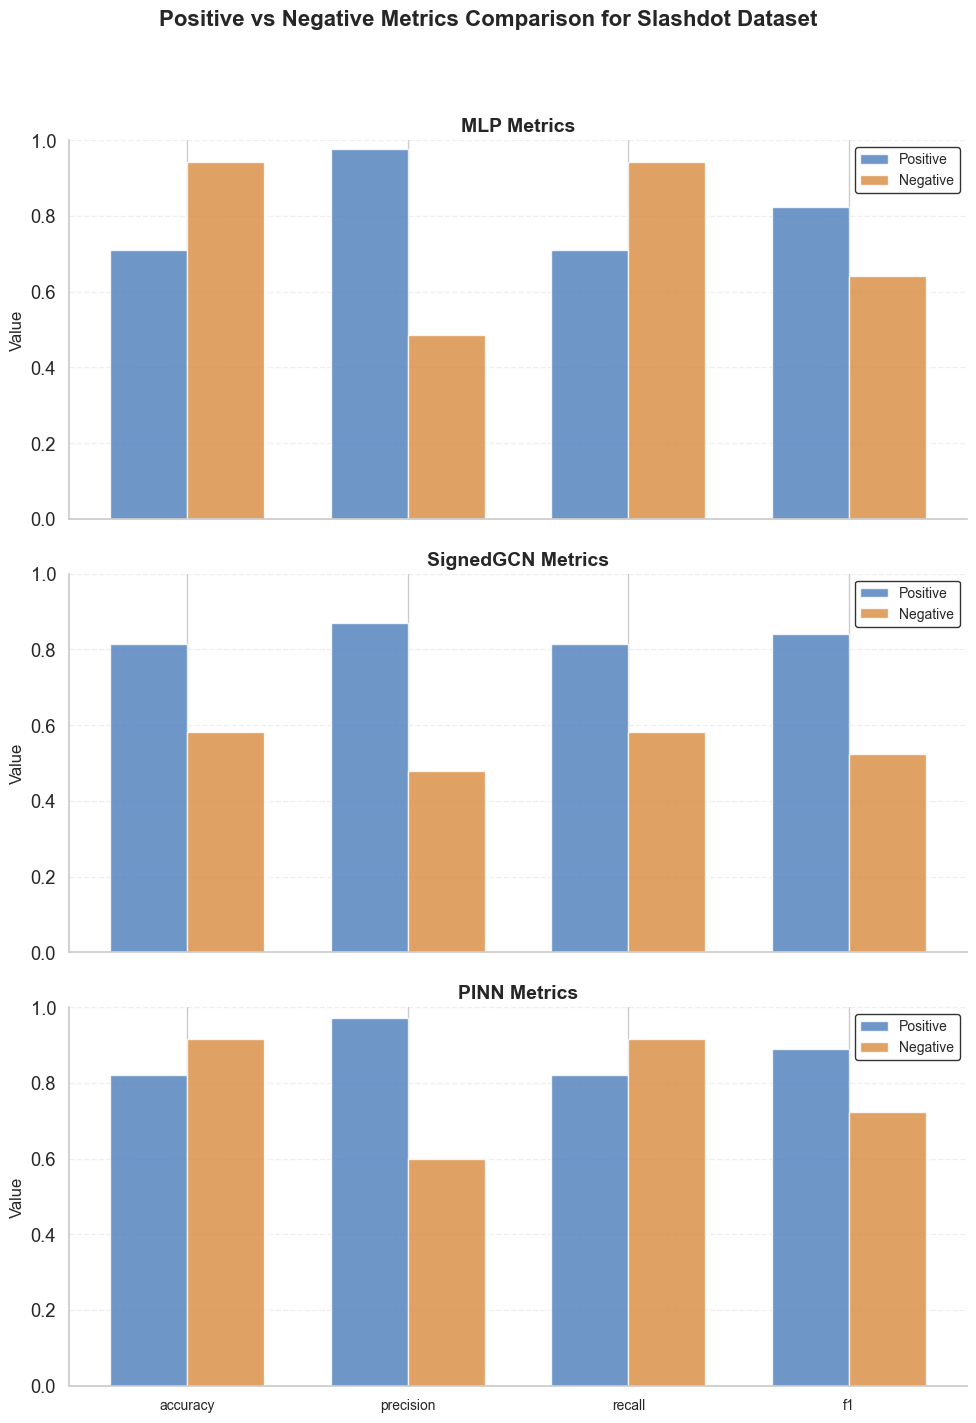

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_positive_negative_comparison(metrics_dict):
    """Plot positive and negative metrics comparison for each model in a bar chart with professional aesthetics."""
    models = list(metrics_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    x = np.arange(len(metrics))
    width = 0.35
    
    # Updated color palette with darker shades
    positive_color = '#4a7cba'  # Darker blue
    negative_color = '#d88a3d'   # Darker orange
    
    fig, axs = plt.subplots(len(models), 1, figsize=(10, 5 * len(models)), sharex=True)
    fig.suptitle('Positive vs Negative Metrics Comparison for Slashdot Dataset', fontsize=16, fontweight='bold')
    
    for i, (model, ax) in enumerate(zip(models, axs)):
        positive_values = [metrics_dict[model]['positive'][metric] for metric in metrics]
        negative_values = [metrics_dict[model]['negative'][metric] for metric in metrics]
        
        ax.bar(x - width/2, positive_values, width, label='Positive', color=positive_color, alpha=0.8)
        ax.bar(x + width/2, negative_values, width, label='Negative', color=negative_color, alpha=0.8)
        
        ax.set_ylabel('Value', fontsize=12)
        ax.set_title(f'{model} Metrics', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, fontsize=10)
        ax.legend(loc='upper right', fontsize=10, frameon=True, edgecolor='black')
        ax.set_ylim(0, 1)
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the title
    plt.savefig('positive_negative_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Assuming metrics_dict is your dictionary containing metrics for all models
metrics_dict = {
    'MLP': mlp_metrics,
    'SignedGCN': gcn_metrics,
    'PINN': pinn_metrics
}

# Plot positive vs negative metrics comparison
plot_positive_negative_comparison(metrics_dict)

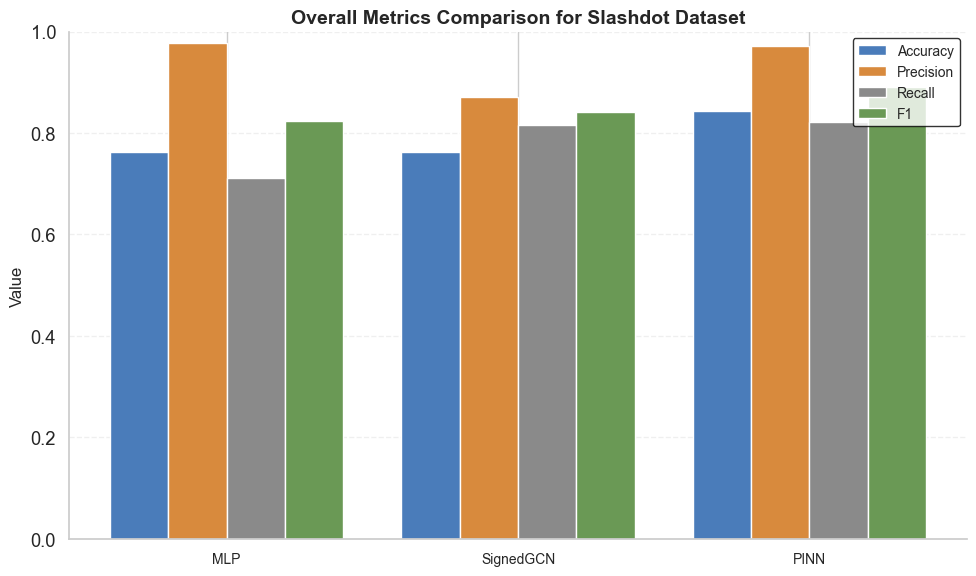

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_overall_metrics(metrics_dict):
    """Plot overall metrics for all models in a single bar chart with professional aesthetics."""
    models = list(metrics_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    x = np.arange(len(models))
    width = 0.2
    
    # Updated color palette
    colors = ['#4a7cba',  # Darker blue
              '#d88a3d',  # Darker orange
              '#8a8a8a', # Grey
              '#6a9955']  # Complementary green
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, metric in enumerate(metrics):
        values = [metrics_dict[model]['overall'][metric] for model in models]
        ax.bar(x + i * width, values, width, label=metric.capitalize(), color=colors[i])
    
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title('Overall Metrics Comparison for Slashdot Dataset', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(models, fontsize=10)
    ax.legend(loc='upper right', fontsize=10, frameon=True, edgecolor='black')
    ax.set_ylim(0, 1)
    
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('overall_metrics_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Assuming metrics_dict is your dictionary containing metrics for all models
metrics_dict = {
    'MLP': mlp_metrics,
    'SignedGCN': gcn_metrics,
    'PINN': pinn_metrics
}

# Plot overall metrics comparison
plot_overall_metrics(metrics_dict)